Let's find the optimal number of foreground parameters by looking at the BIC without subtracting the best-fit 21cm model. This isn't ideal but can probably be justified. The main benefit is that everything is linear, and we get the solution with a few matrix multiplies instead of running $\mathrm{NBINS}^{N}$ MCMCs where N is the number of foreground parameters swept over.

The math can be found here: https://www.overleaf.com/read/ppwbchczwdpq#17a8f5

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import mistsim as ms

In [92]:
rng = np.random.default_rng(seed=1913)
TRUE_PARAMS = {"a": -0.2, "w": 20, "nu21": 80}
# Parameter bounds (a, w, nu21)
BOUNDS = np.array([[-1.0, 1.0], [1.0, 60.0], [45.0, 105.0]])
NDIM = len(BOUNDS)
N_PARTICLES = 1000
NBINS = 8
NFG = np.arange(4, 9)

lst, freq, temp = ms.utils.read_hdf5_convolution(
    "../simulations/CSA/CSA_beam_nominal_gsm_no_az_no_tilts_no_mountains.hdf5",
)
indx = (freq >= 45) * (freq <= 105)
freq = freq[indx]
temp = temp[:, indx]
nspec, nfreq = temp.shape
fg_mean = temp.mean(axis=0)  # avg spectrum, fg only
# this discards the last 6 min integration
fg_bin = temp[: -(nspec % NBINS)].reshape(nspec // NBINS, NBINS, nfreq)
tint_ratio = fg_bin.shape[0] / nspec
fg_bin = fg_bin.mean(axis=0)

# noise
noise_75 = 3e-3
t75 = fg_mean[freq == 75]
noise, noise_cov_inv = ms.utils.gen_noise(
    fg_bin, t75, ref_noise=noise_75, tint_ratio=tint_ratio
)

# injected 21cm signal
true_t21 = ms.utils.gauss(freq, **TRUE_PARAMS)

In [93]:
def chi_sq(d, sigma_prime, sigma_inv):
    V = np.eye(d.size) - sigma_prime @ sigma_inv
    return d.T @ V.T @ sigma_inv @ V @ d 

(61, 8)


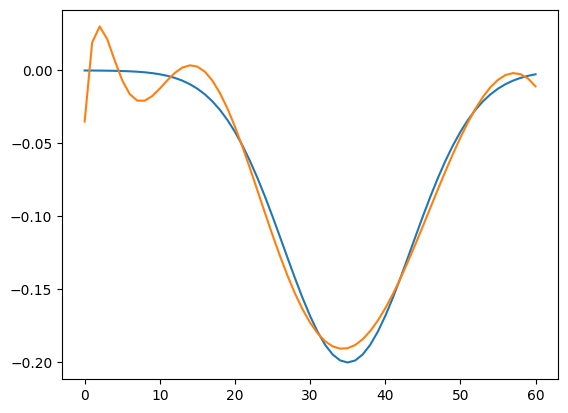

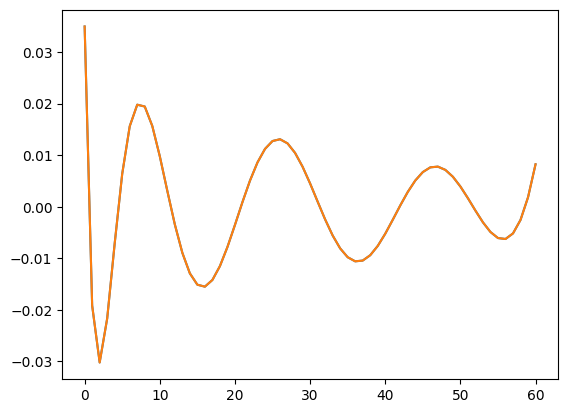

In [94]:
A = lst_bin.A
print(A.shape)
null = np.zeros_like(true_t21)
theta_hat, dstar = ms.lstbin.fg_mle(null, A, lst_bin.sigma_inv, true_t21, 0)

plt.figure()
plt.plot(true_t21)
plt.plot(A @ theta_hat)
plt.show()

plt.figure()
plt.plot(-A @ theta_hat + true_t21)
plt.plot(dstar)
plt.show()

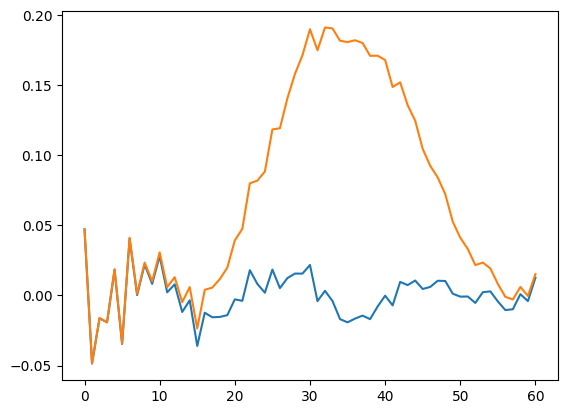

In [95]:
d = lst_bin.spec #+ lst_bin.injected_t21
theta, dstar = lst_bin.bin_fg_mle(0)
V = np.eye(d.size) - lst_bin.sigma_fg @ lst_bin.sigma_inv
plt.figure()
plt.plot(dstar)
plt.plot(d - lst_bin.A @ theta)
plt.show()

In [98]:
results = {}
residuals = {}
for i in range(NBINS):
    results[i] = {}
    for n in NFG:
        #print(f"NFG = {n}")                                                    
        lst_bin = ms.lstbin.LSTBin(
            freq, fg_bin[i]+noise[i], np.diag(noise_cov_inv[i]), 0, n
        )
        residual = lst_bin.bin_fg_mle(0)[1]
        chi_square = residual.T @ lst_bin.sigma_inv @ residual
        print(np.allclose(chi_square, chi_sq(lst_bin.spec+lst_bin.injected_t21, lst_bin.sigma_fg, lst_bin.sigma_inv)))
        results[i][n] =  chi_square + (n+3) * np.log(nfreq)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [99]:
for i in range(NBINS):
    am = np.argmin(list(results[i].values()))
    print(NFG[am])

6
7
6
6
6
6
6
6


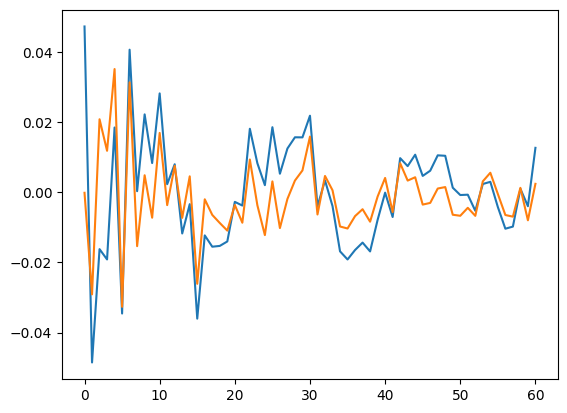

In [77]:
plt.figure()
plt.plot(residual)
plt.plot(noise[-1])
plt.show()